# Interactive Langevin Thermostat
based on: https://github.com/pyiron/pyiron_contrib/blob/master/pyiron_contrib/protocol/primitive/one_state.py

In [1]:
%matplotlib inline

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
from pyiron import Project

In [5]:
from pyiron import Notebook as nb

In [6]:
from scipy.constants import physical_constants

# Parameter

In [7]:
temperature = 1000.0 
cell_size = 3
steps = 10000

# Project

In [8]:
pr = Project('md_' + str(temperature).replace('.', '_'))

In [9]:
pr.remove_jobs(recursive=True)

This group does not exist in the HDF5 file lmp_interactive


# Structure

In [10]:
basis = pr.create_structure('Fe', 'bcc', 2.78)

In [11]:
basis.set_repeat([cell_size, cell_size, cell_size])

In [12]:
len(basis)

54

# Equilibration - Lammps MD for comparison

In [13]:
ham_equ = pr.create_job(pr.job_type.Lammps, 'lmpequ')

In [14]:
ham_equ.structure = basis

In [15]:
ham_equ.potential = 'Fe_C_Becquart_eam'

In [16]:
ham_equ.calc_md(temperature=temperature, n_print=1, n_ionic_steps=steps, langevin=True)

In [17]:
ham_equ.run()

The job lmpequ was saved and received the ID: 4948040


In [18]:
ham_equ.decompress()

In [19]:
ham_equ['log.lammps'][-30:]

['    9998     847.998126308807    -207.010598129557    -201.201143008937     185466.250250248     7781.69678076173     4507.65493113195      189780.95766666     772.244621038435     179740.184049824           580.093704 \n',
 '    9999     872.578791431071    -207.066105520868    -201.088253482339     184560.019986913     7516.95652941523     4559.02055753205     190271.002628124     1208.42468673106     180291.925053034           580.093704 \n',
 '   10000     875.312652971048    -207.123850405555    -201.127269262056     183660.586459235     7175.71659155665     4849.62369463125     190245.839173707     1892.78050832314     180444.863623847           580.093704 \n',
 'Loop time of 3.1128 on 1 procs for 10000 steps with 54 atoms\n',
 '\n',
 'Performance: 277.564 ns/day, 0.086 hours/ns, 3212.543 timesteps/s\n',
 '97.6% CPU use with 1 MPI tasks x no OpenMP threads\n',
 '\n',
 'MPI task timing breakdown:\n',
 'Section |  min time  |  avg time  |  max time  |%varavg| %total\n',
 '-------

# Interactive Job

## Constants

In [20]:
KB = physical_constants['Boltzmann constant in eV/K'][0]
EV_TO_U_ANGSQ_PER_FSSQ = physical_constants['Faraday constant'][0] / 10**7
U_ANGSQ_PER_FSSQ_TO_EV = 1. / EV_TO_U_ANGSQ_PER_FSSQ

In [21]:
overheat_fraction = 2.0
damping_timescale = 100.
time_step = 1

## Functions 
copied from: https://github.com/pyiron/pyiron_contrib/blob/master/pyiron_contrib/protocol/primitive/one_state.py

In [22]:
def langevin_delta_v(temperature, time_step, masses, damping_timescale, velocities):
    """
    Velocity changes due to the Langevin thermostat.
    Args:
        temperature (float): The target temperature in K.
        time_step (float): The MD time step in fs.
        masses (numpy.ndarray): Per-atom masses in u with a shape (N_atoms, 1).
        damping_timescale (float): The characteristic timescale of the thermostat in fs.
        velocities (numpy.ndarray): Per-atom velocities in angstrom/fs.
    Returns:
        (numpy.ndarray): Per atom accelerations to use for changing velocities.
    """
    drag = -0.5 * time_step * velocities / damping_timescale
    noise = np.sqrt(EV_TO_U_ANGSQ_PER_FSSQ * KB * temperature * time_step / (masses * damping_timescale)) \
        * np.random.randn(*velocities.shape)
    noise -= np.mean(noise, axis=0)
    return drag + noise

In [23]:
def convert_to_acceleration(forces, masses):
    return forces * EV_TO_U_ANGSQ_PER_FSSQ / masses

## Create Job

In [24]:
job_name = 'lmp_interactive'
ham_lmp = pr.create_job(pr.job_type.Lammps, job_name)
ham_lmp.structure = ham_equ.get_structure()
ham_lmp.potential = 'Fe_C_Becquart_eam'
ham_lmp.server.run_mode.interactive = True
ham_lmp.run()

The job lmp_interactive was saved and received the ID: 4948041


## Initial velocities

In [25]:
positions = ham_equ.get_structure().positions

In [26]:
masses = np.array([a.mass for a in ham_lmp.structure[:]])[:, np.newaxis]

In [27]:
forces = ham_lmp.output.forces[-1]

In [28]:
vel_scale = np.sqrt(EV_TO_U_ANGSQ_PER_FSSQ * KB * temperature / masses) * np.sqrt(overheat_fraction)
vel_dir = np.random.randn(len(masses), 3)
velocities = vel_scale * vel_dir
velocities -= np.mean(velocities, axis=0)

In [29]:
gamma = masses / damping_timescale

## Langevin 

In [30]:
eng_pot_lst, eng_kin_lst = [], []
for i in range(steps):
    # first half step
    acceleration = convert_to_acceleration(forces, masses)
    vel_half = velocities + 0.5 * acceleration * time_step
    
    # damping 
    if damping_timescale is not None:
        vel_half += langevin_delta_v(
            temperature,
            time_step,
            masses,
            damping_timescale,
            velocities
        )
    
    # postion update 
    pos_step = positions + vel_half * time_step
    
    # communicate with Lammps 
    positions = pos_step.copy()
    ham_lmp.interactive_positions_setter(pos_step)
    ham_lmp.interactive_execute()
    forces = np.array(ham_lmp.interactive_forces_getter())
    eng_pot_lst.append(ham_lmp.interactive_energy_pot_getter())
    
    # second half step 
    acceleration = convert_to_acceleration(forces, masses)
    vel_step = velocities + 0.5 * acceleration * time_step
    
    # damping 
    if damping_timescale is not None:
        vel_step += langevin_delta_v(
            temperature,
            time_step,
            masses,
            damping_timescale,
            velocities
        )
        
    # kinetic energy
    kinetic_energy = 0.5 * np.sum(masses * vel_step * vel_step) / EV_TO_U_ANGSQ_PER_FSSQ
    eng_kin_lst.append(kinetic_energy)
    velocities = vel_step.copy()

In [31]:
ham_lmp.interactive_close()

# Plot

In [32]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,4948040,finished,Fe54,lmpequ,/lmpequ,/cmmc/u/,janj/pyiron/projects/2020/2020-02-21-pyiron-meeting/md_1000_0/,2020-02-21 07:12:20.866891,2020-02-21 07:12:45.099355,24.0,janj@cmti001#1,Lammps,0.1,None,None
1,4948041,finished,Fe54,lmp_interactive,/lmp_interactive,/cmmc/u/,janj/pyiron/projects/2020/2020-02-21-pyiron-meeting/md_1000_0/,2020-02-21 07:12:59.670048,2020-02-21 07:13:10.226540,10.0,janj@cmti001#1,Lammps,0.1,None,None


Text(0, 0.5, 'Energy (eV)')

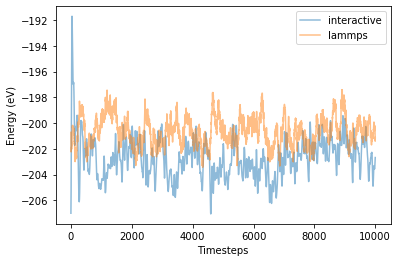

In [33]:
plt.plot(eng_pot_lst, alpha=0.5, label='interactive')
plt.plot(ham_equ['output/generic/energy_tot'], alpha=0.5, label='lammps')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Energy (eV)')